In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian, threshold_otsu
from skimage.transform import resize
from skimage import io
import pickle
from skimage.measure import regionprops

import matplotlib.pyplot as plt
import torch
import time
import model.model_cnnvae_conditional
import model.optimizer as optimizer
from sklearn.decomposition import PCA
import pandas as pd
import torchvision

from PIL import Image 

import scanpy
import anndata as ad
import seaborn as sns

In [2]:
nProt=6
holdOutSamples_samples=[['HV1','P22','P14','P27','HV3','P46','P24','P37'],
                        ['HV5','P68','P44','P42','HV7','P15','P55','P59'],
                        ['HV8','P47','P63','P70','HV2','P57','P72','P83'],
                        ['HV4','P16','P18','P62','HV6','P52','P41','P38'],
                        ['HV1','P84','P50','P48','HV2','P22','P56','P27'],
                        ['HV3','P46','P14','P37','HV4','P68','P44','P42'],
                        ['HV5','P15','P24','P59','HV6','P47','P55','P70'],
                        ['HV7','P57','P63','P83','HV8','P16','P18','P62'],
                        ['HV1','P52','P72','P38','HV5','P84','P41','P48'],
                        ['HV2','P22','P50','P27','HV3','P68','P24','P59'],
                        ['HV4','P47','P56','P37','HV7','P16','P44','P70'],
                        ['HV6','P46','P14','P42','HV8','P15','P55','P83']]

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

deShared_centered_2bins=[None]*len(holdOutSamples_samples)
deD_centered_2bins=[None]*len(holdOutSamples_samples)

deShared_centered_2bins_heldout=[None]*len(holdOutSamples_samples)
deD_centered_2bins_heldout=[None]*len(holdOutSamples_samples)


In [3]:
name_lord='splitChannels_conditional_lord_withNoise_bce'
modelname_lord='cnn_vae_pbmc_lord'
plotsavepath_lord=os.path.join('/data/xinyi/c2p/plots/',modelname_lord,name_lord)

plotsavepath_p_protein=os.path.join(plotsavepath_lord,'protein')


In [4]:
sourceDir='/data/xinyi/c2p/data/chromark'

pnames=np.array(['cd16', 'cd3', 'cd4', 'cd8', 'gh2ax', 'lamin'])

In [5]:
plotsavepath_de=os.path.join(plotsavepath_p_protein,'de')
if not os.path.exists(plotsavepath_de):
    os.mkdir(plotsavepath_de)

with open(os.path.join(plotsavepath_de,'de_shared_all_centered_2bins'), 'rb') as output:
    deShared_centered_2bins=pickle.load(output)
with open(os.path.join(plotsavepath_de,'de_d_all_centered_2bins'), 'rb') as output:
    deD_centered_2bins=pickle.load(output)
    
with open(os.path.join(plotsavepath_de,'de_shared_all_centered_2bins_heldout'), 'rb') as output:
    deShared_centered_2bins_heldout=pickle.load(output)
with open(os.path.join(plotsavepath_de,'de_d_all_centered_2bins_heldout'), 'rb') as output:
    deD_centered_2bins_heldout=pickle.load(output)


### taking into account direction of fold change

cd16


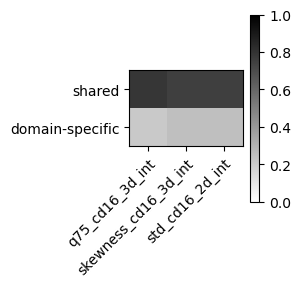

cd3


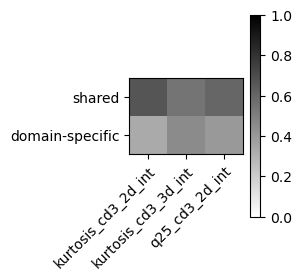

cd4


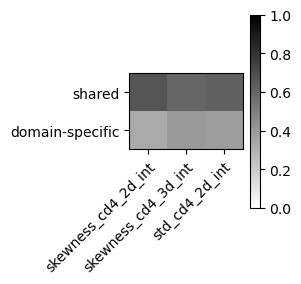

cd8


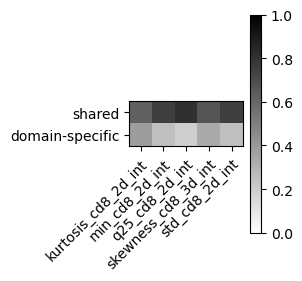

gh2ax


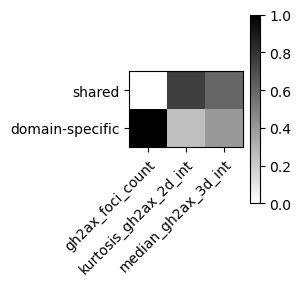

lamin


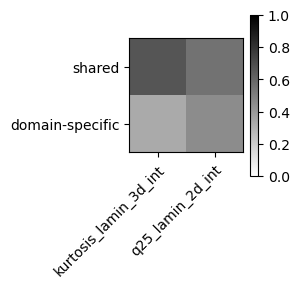

In [76]:
pval_thresh=0.05
minAgreement=1
fc_thresh=1.4
dePC_shared=10
dePC_d=10
minCount=0

for p in pnames:
    print(p)
    with open(os.path.join(sourceDir,'ls_cc_mostConnected_'+p), 'rb') as output:
        ls_cc_mostConnected=pickle.load(output)
    with open(os.path.join(sourceDir,'nmco_allfeatures_names_finite_'+p), 'rb') as output:
        nmco_names_finite=pickle.load(output)
    
    resDEsampling=np.zeros((2,nmco_names_finite.size))
    for pc_i in range(dePC_shared):
        resLogFC={0:np.array([]),-1:np.array([]),1:np.array([])}
        resNames={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        resAgreement={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        for h in range(len(holdOutSamples_samples)):
    #         print('sample ',h)
            deRes_shared_centered=deShared_centered_2bins[h][p]
            deRes_shared_centered_heldout=deShared_centered_2bins_heldout[h][p]
            for deDirection in resLogFC.keys():
    #             print(deDirection)
                resNames_h_val=nmco_names_finite[deRes_shared_centered[pc_i][str(deDirection)].names.astype(int)[np.logical_and(deRes_shared_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]]
                resValues_h_val=deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges[np.logical_and(deRes_shared_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]
                resNames_h_val,mostConnectedIdx,_=np.intersect1d(resNames_h_val,ls_cc_mostConnected,return_indices=True)
                resValues_h_val=np.array(resValues_h_val)[mostConnectedIdx]

                resNames_h_heldout=nmco_names_finite[deRes_shared_centered_heldout[pc_i][str(deDirection)].names.astype(int)[np.logical_and(deRes_shared_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]]
                resValues_h_heldout=deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges[np.logical_and(deRes_shared_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]
                resNames_h_heldout,mostConnectedIdx,_=np.intersect1d(resNames_h_heldout,ls_cc_mostConnected,return_indices=True)
                resValues_h_heldout=np.array(resValues_h_heldout)[mostConnectedIdx]

                resNames_h,valIdx_h,heldoutIdx_h=np.intersect1d(resNames_h_val,resNames_h_heldout,return_indices=True)
                sameDir=np.equal(resValues_h_val[valIdx_h]>0,resValues_h_heldout[heldoutIdx_h]>0)
    
                resAgreement[deDirection]=np.concatenate((resAgreement[deDirection],resNames_h[sameDir]))
                for fidx in range(np.sum(sameDir)):
                    f=str(resNames_h[sameDir][fidx])
                    if f not in resNames[deDirection]:
                        resNames[deDirection]=np.concatenate((resNames[deDirection],[f]))
                        resLogFC[deDirection]=np.concatenate((resLogFC[deDirection],[resValues_h_val[valIdx_h[sameDir]][fidx]]))
                    else:
                        fidx_res=np.where(resNames[deDirection]==f)
                        resLogFC[deDirection][fidx_res]+=resValues_h_val[valIdx_h[sameDir]][fidx]

        
        for deDirection in resLogFC.keys():
            resNames_agree,resAgreement_counts=np.unique(resAgreement[deDirection],return_counts=True)
            resNames_agree=resNames_agree[resAgreement_counts>=minAgreement]
            
            _,shared_unique_idx,_=np.intersect1d(nmco_names_finite,resNames_agree,return_indices=True)

            resDEsampling[0,shared_unique_idx]+=1

    for pc_i in range(dePC_d):
        resLogFC={0:np.array([]),-1:np.array([]),1:np.array([])}
        resNames={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        resAgreement={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        for h in range(len(holdOutSamples_samples)):
    #         print('sample ',h)
            deRes_d_centered=deD_centered_2bins[h][p]
            deRes_d_centered_heldout=deD_centered_2bins_heldout[h][p]
            for deDirection in resLogFC.keys():
    #             print(deDirection)
                if str(deDirection) not in deRes_d_centered[pc_i] or str(deDirection) not in deRes_d_centered_heldout[pc_i]:
                    continue
                resNames_h_val=nmco_names_finite[deRes_d_centered[pc_i][str(deDirection)].names.astype(int)[np.logical_and(deRes_d_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]]
                resValues_h_val=deRes_d_centered[pc_i][str(deDirection)].logfoldchanges[np.logical_and(deRes_d_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]
                resNames_h_val,mostConnectedIdx,_=np.intersect1d(resNames_h_val,ls_cc_mostConnected,return_indices=True)
                resValues_h_val=np.array(resValues_h_val)[mostConnectedIdx]

                resNames_h_heldout=nmco_names_finite[deRes_d_centered_heldout[pc_i][str(deDirection)].names.astype(int)[np.logical_and(deRes_d_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]]
                resValues_h_heldout=deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges[np.logical_and(deRes_d_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]
                resNames_h_heldout,mostConnectedIdx,_=np.intersect1d(resNames_h_heldout,ls_cc_mostConnected,return_indices=True)
                resValues_h_heldout=np.array(resValues_h_heldout)[mostConnectedIdx]

                resNames_h,valIdx_h,heldoutIdx_h=np.intersect1d(resNames_h_val,resNames_h_heldout,return_indices=True)
                sameDir=np.equal(resValues_h_val[valIdx_h]>0,resValues_h_heldout[heldoutIdx_h]>0)

                resAgreement[deDirection]=np.concatenate((resAgreement[deDirection],resNames_h[sameDir]))
                for fidx in range(np.sum(sameDir)):
                    f=str(resNames_h[sameDir][fidx])
                    if f not in resNames[deDirection]:
                        resNames[deDirection]=np.concatenate((resNames[deDirection],[f]))
                        resLogFC[deDirection]=np.concatenate((resLogFC[deDirection],[resValues_h_val[valIdx_h[sameDir]][fidx]]))
                    else:
                        fidx_res=np.where(resNames[deDirection]==f)
                        resLogFC[deDirection][fidx_res]+=resValues_h_val[valIdx_h[sameDir]][fidx]
        for deDirection in resLogFC.keys():
            resNames_agree,resAgreement_counts=np.unique(resAgreement[deDirection],return_counts=True)
            resNames_agree=resNames_agree[resAgreement_counts>=minAgreement]
            _,d_unique_idx,_=np.intersect1d(nmco_names_finite,resNames_agree,return_indices=True)

            resDEsampling[1,d_unique_idx]+=1
            
    resDEsampling_norm=np.copy(resDEsampling)
    resDEsampling_names=nmco_names_finite[np.sum(resDEsampling_norm,axis=0)>minCount]
    resDEsampling_norm=np.copy(resDEsampling_norm[:,np.sum(resDEsampling_norm,axis=0)>minCount])
    resDEsampling_norm=resDEsampling_norm/np.sum(resDEsampling_norm,axis=0,keepdims=True)

    with open(os.path.join(sourceDir,'ls_cc_mostConnected_'+p), 'rb') as output:
        ls_cc_mostConnected=pickle.load(output)
    
    _,mostConnectedIdx,_=np.intersect1d(resDEsampling_names,ls_cc_mostConnected,return_indices=True)
    
    fig, ax = plt.subplots(figsize=(3, 3))
    im=ax.imshow(resDEsampling_norm[:,mostConnectedIdx],cmap='binary',vmin=0,vmax=1)
    ax.set_yticks(np.arange(resDEsampling_norm.shape[0]))
    ax.set_yticklabels(np.array(['shared','domain-specific']))
    ax.set_xticks(np.arange(mostConnectedIdx.size))
    ax.set_xticklabels(resDEsampling_names[mostConnectedIdx])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.colorbar(im)
    fig.tight_layout()
    plt.savefig(os.path.join(plotsavepath_de,p+'_de_groupNMCO_pcShared'+str(dePC_shared)+'_pcD'+str(dePC_d)+'_nocommon_sameDir.pdf'))
    plt.show()
    plt.close()

In [48]:
plotsavepath_de_pc=os.path.join(plotsavepath_de,'byPC')
if not os.path.exists(plotsavepath_de_pc):
    os.mkdir(plotsavepath_de_pc)

cd16


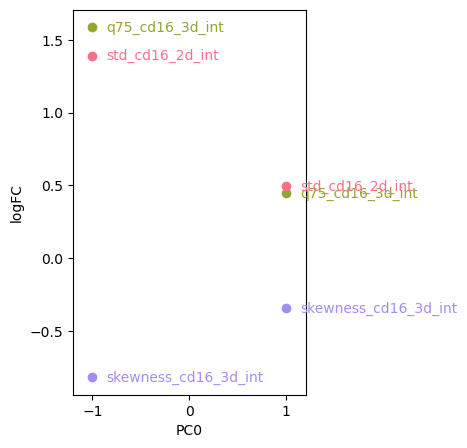

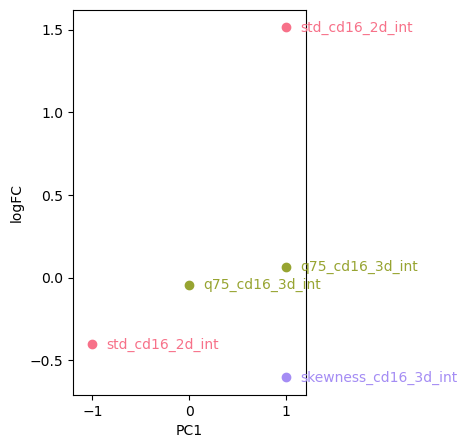

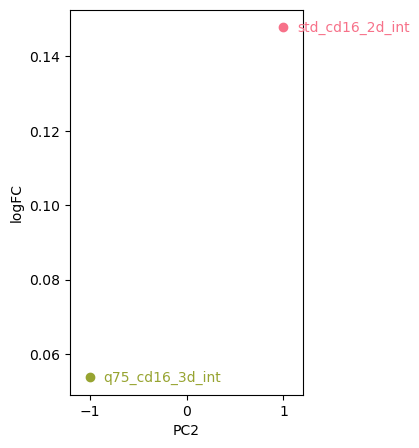

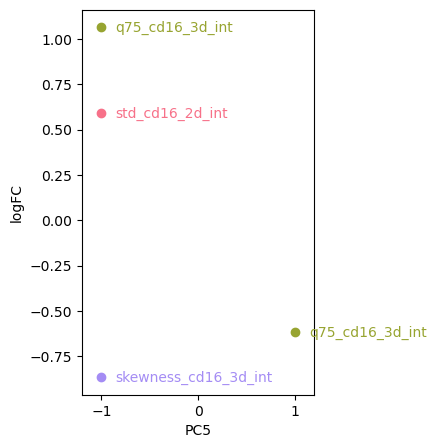

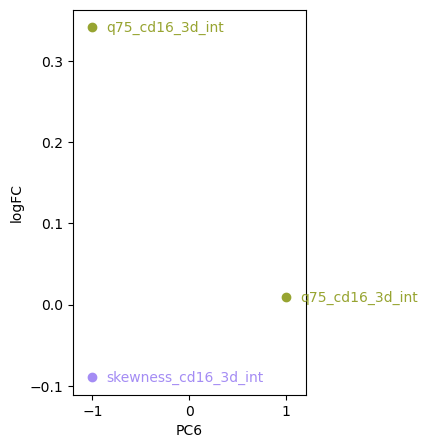

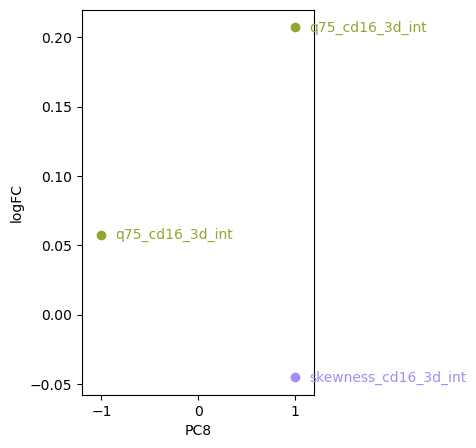

cd3


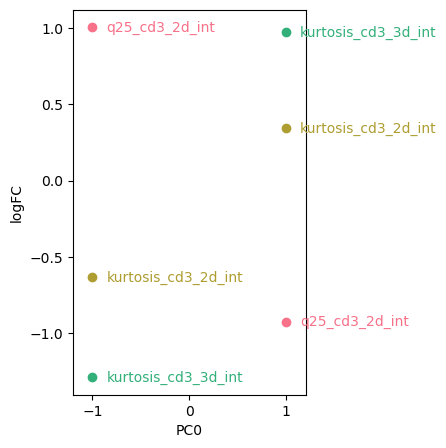

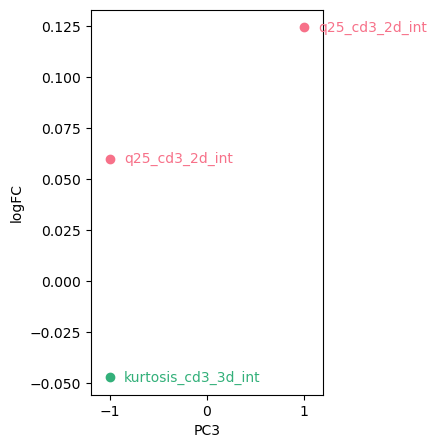

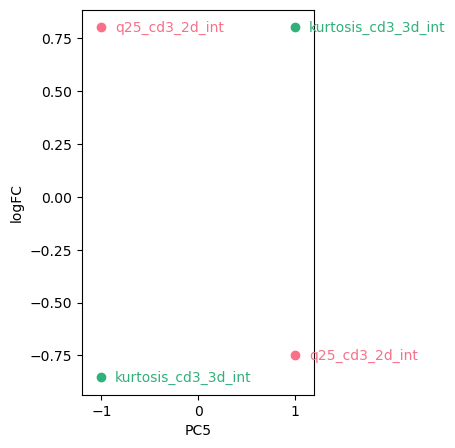

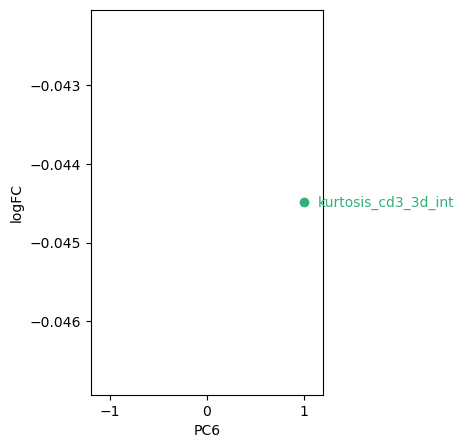

cd4


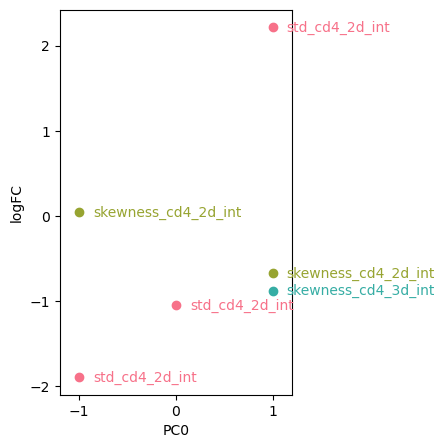

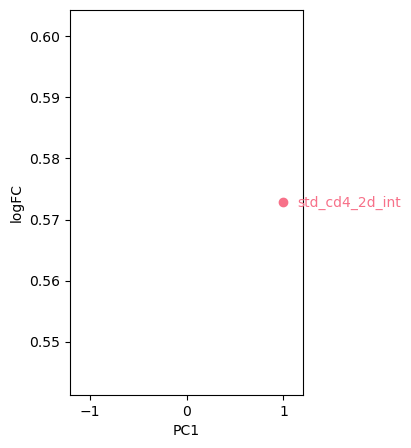

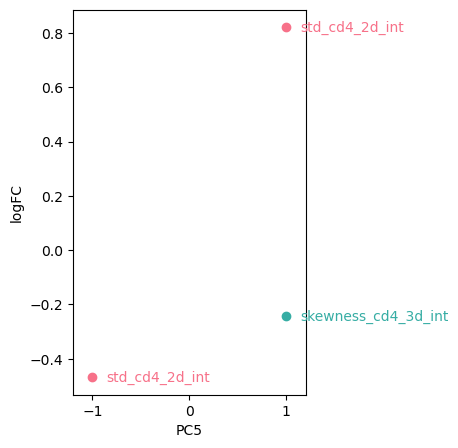

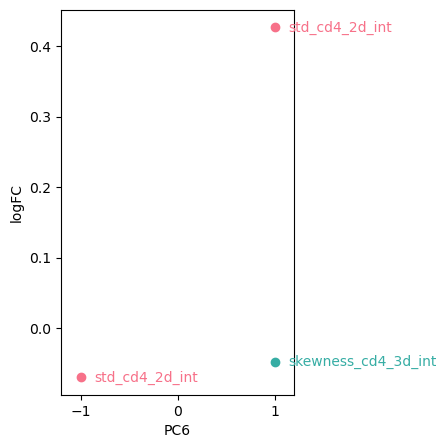

cd8


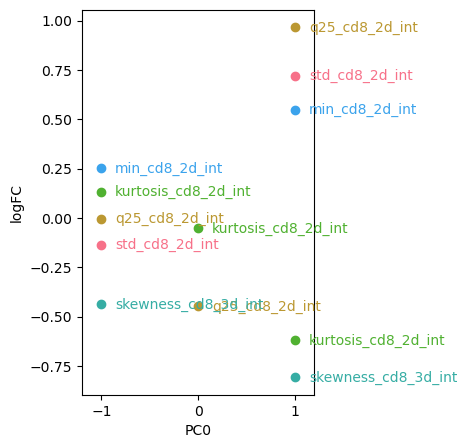

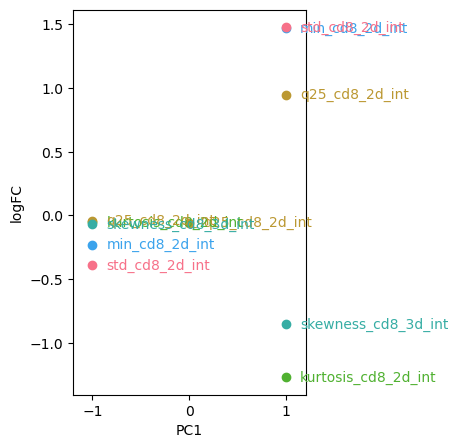

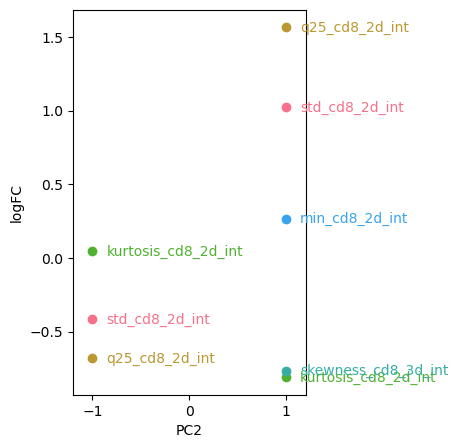

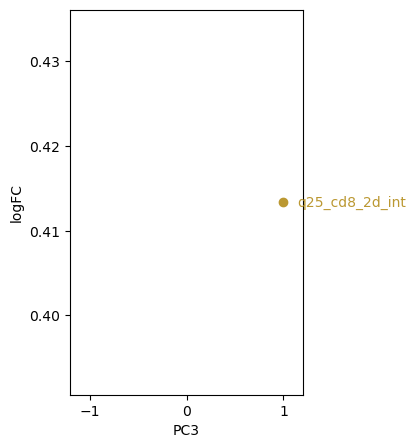

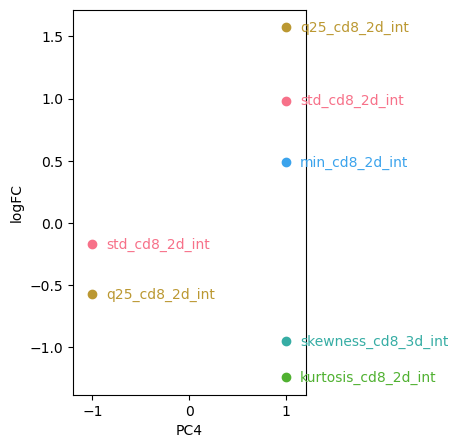

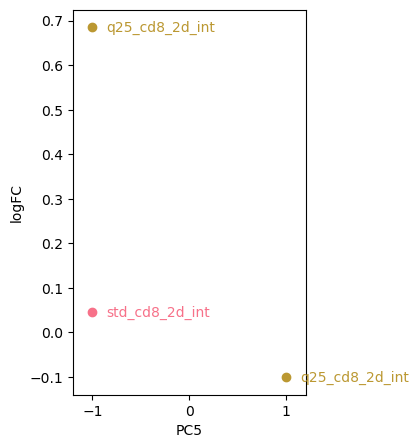

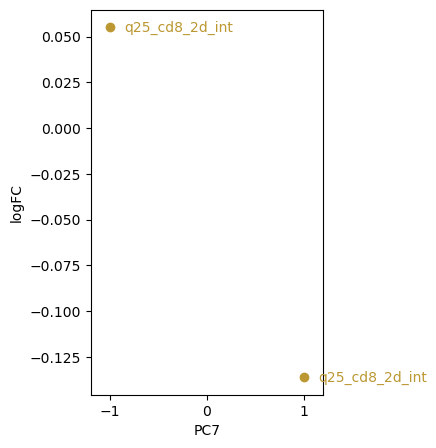

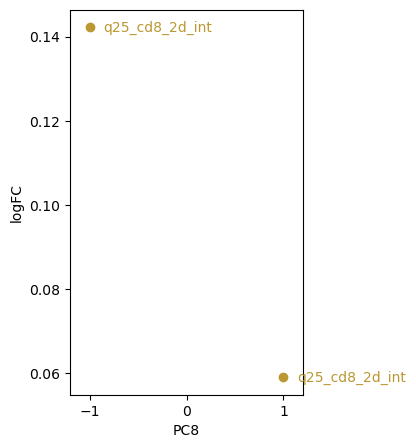

gh2ax


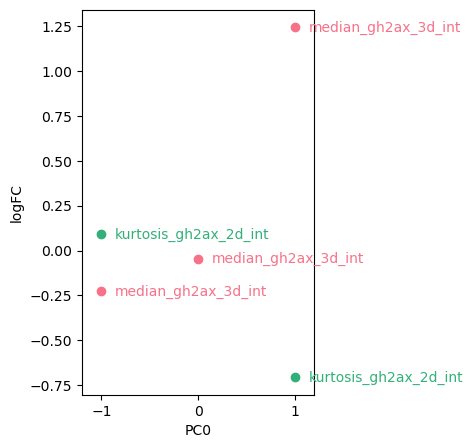

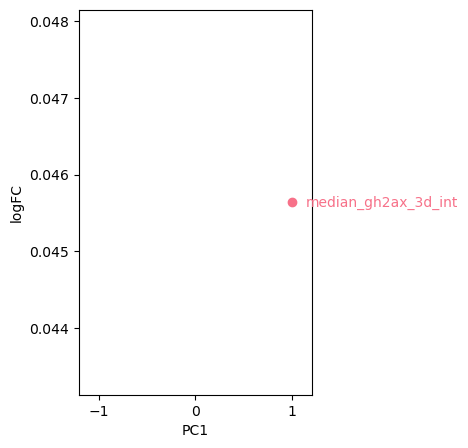

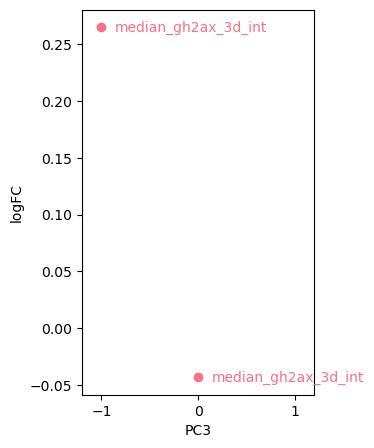

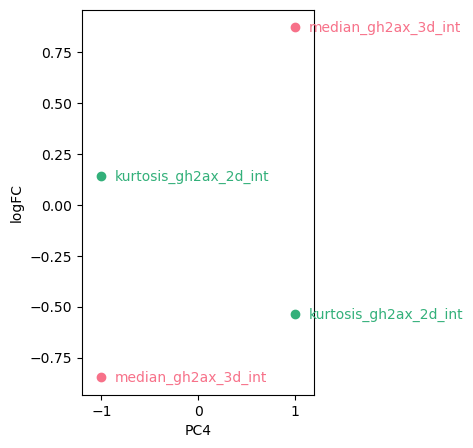

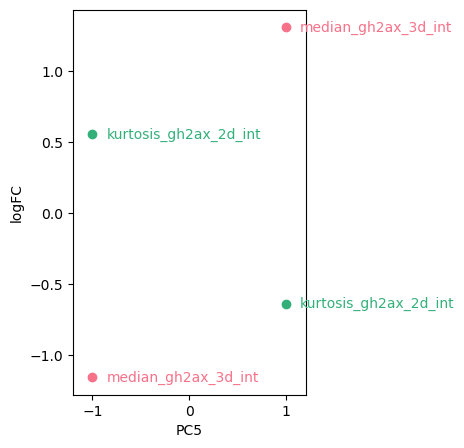

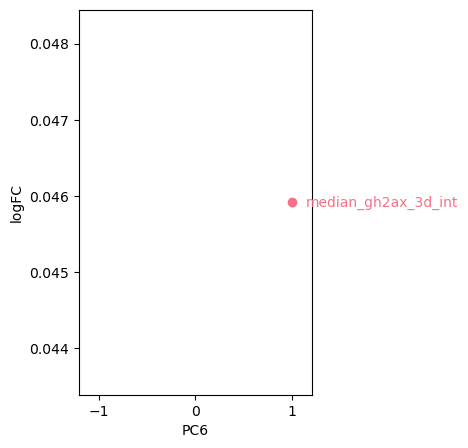

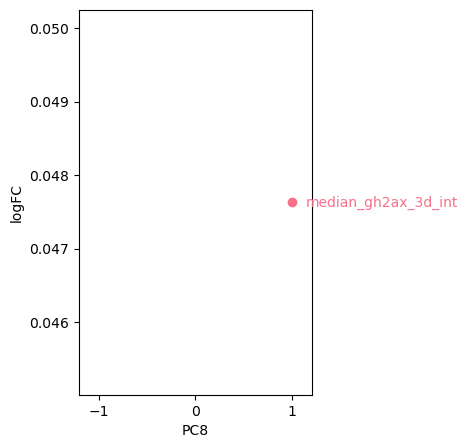

lamin


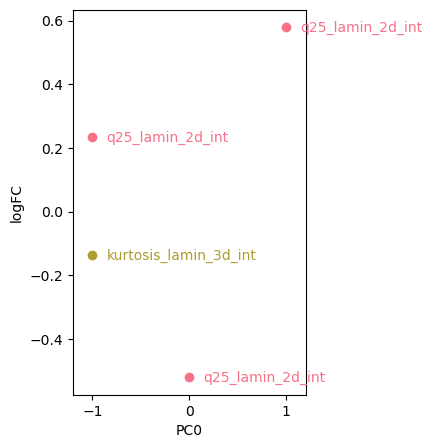

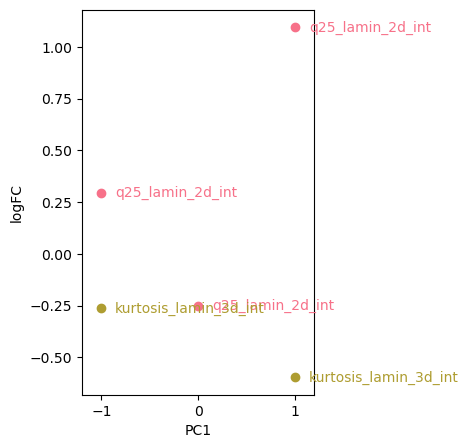

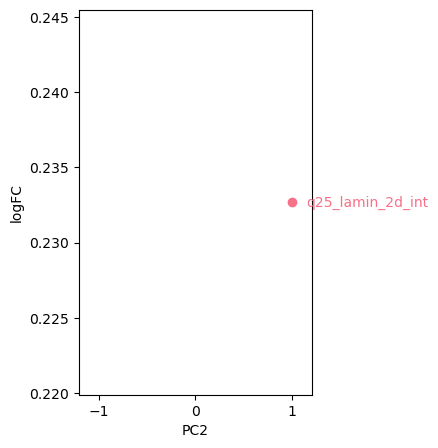

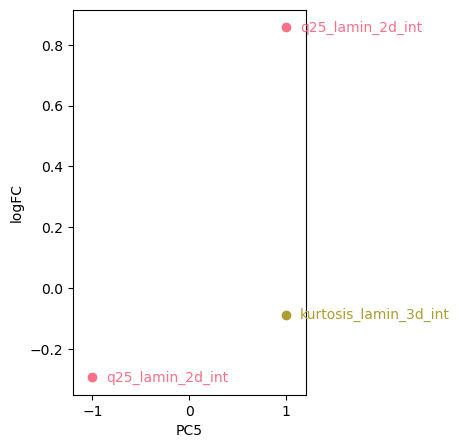

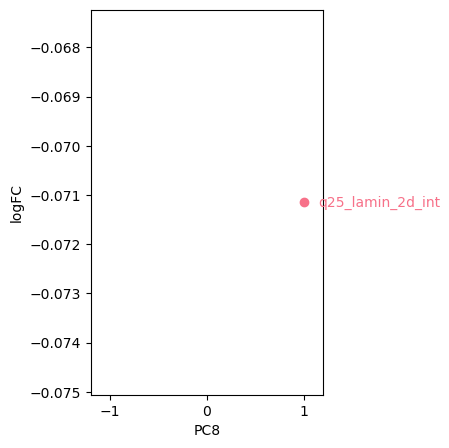

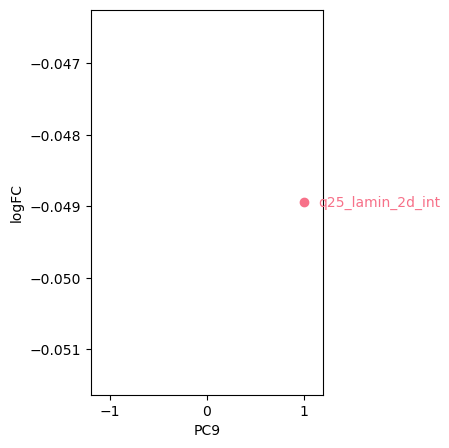

In [57]:
minAgreement=1
fc_thresh=1.4
dePC_shared=10
dePC_d=10

for p in pnames:
    print(p)
    with open(os.path.join(sourceDir,'ls_cc_mostConnected_'+p), 'rb') as output:
        ls_cc_mostConnected=pickle.load(output)
    with open(os.path.join(sourceDir,'nmco_allfeatures_names_finite_'+p), 'rb') as output:
        nmco_names_finite=pickle.load(output)
    colortest=sns.color_palette("husl", len(ls_cc_mostConnected))
    
    for pc_i in range(dePC_shared):
        resLogFC={0:np.array([]),-1:np.array([]),1:np.array([])}
        resNames={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        resAgreement={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        for h in range(len(holdOutSamples_samples)):
    #         print('sample ',h)
            deRes_shared_centered=deShared_centered_2bins[h][p]
            deRes_shared_centered_heldout=deShared_centered_2bins_heldout[h][p]
            for deDirection in resLogFC.keys():
    #             print(deDirection)
                resNames_h_val=nmco_names_finite[deRes_shared_centered[pc_i][str(deDirection)].names.astype(int)[np.logical_and(deRes_shared_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]]
                resValues_h_val=deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges[np.logical_and(deRes_shared_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]
                resNames_h_val,mostConnectedIdx,_=np.intersect1d(resNames_h_val,ls_cc_mostConnected,return_indices=True)
                resValues_h_val=np.array(resValues_h_val)[mostConnectedIdx]

                resNames_h_heldout=nmco_names_finite[deRes_shared_centered_heldout[pc_i][str(deDirection)].names.astype(int)[np.logical_and(deRes_shared_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]]
                resValues_h_heldout=deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges[np.logical_and(deRes_shared_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_shared_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]
                resNames_h_heldout,mostConnectedIdx,_=np.intersect1d(resNames_h_heldout,ls_cc_mostConnected,return_indices=True)
                resValues_h_heldout=np.array(resValues_h_heldout)[mostConnectedIdx]

                resNames_h,valIdx_h,heldoutIdx_h=np.intersect1d(resNames_h_val,resNames_h_heldout,return_indices=True)
                sameDir=np.equal(resValues_h_val[valIdx_h]>0,resValues_h_heldout[heldoutIdx_h]>0)
#                 sameDir=np.repeat(True,resValues_h_val[valIdx_h].size)
    
                resAgreement[deDirection]=np.concatenate((resAgreement[deDirection],resNames_h[sameDir]))
                for fidx in range(np.sum(sameDir)):
                    f=str(resNames_h[sameDir][fidx])
                    if f not in resNames[deDirection]:
                        resNames[deDirection]=np.concatenate((resNames[deDirection],[f]))
                        resLogFC[deDirection]=np.concatenate((resLogFC[deDirection],[resValues_h_val[valIdx_h[sameDir]][fidx]]))
                    else:
                        fidx_res=np.where(resNames[deDirection]==f)
                        resLogFC[deDirection][fidx_res]+=resValues_h_val[valIdx_h[sameDir]][fidx]
        plotCounts=0
        fig, ax = plt.subplots(figsize=(3, 5))
        for deDirection in resLogFC.keys():
            resNames_agree,resAgreement_counts=np.unique(resAgreement[deDirection],return_counts=True)
            resNames_agree=resNames_agree[resAgreement_counts>=minAgreement]
            _,plotIdx,_=np.intersect1d(resNames[deDirection],resNames_agree,return_indices=True)
            plotCounts+=plotIdx.size
            for fidx in range(plotIdx.size):
                ax.scatter(deDirection,resLogFC[deDirection][plotIdx[fidx]]/len(holdOutSamples_samples),color=colortest[ls_cc_mostConnected.index(resNames[deDirection][plotIdx[fidx]])])
                ax.annotate(resNames[deDirection][plotIdx[fidx]],(deDirection,resLogFC[deDirection][plotIdx[fidx]]/len(holdOutSamples_samples)),xytext=(10,-3),textcoords='offset points',color=colortest[ls_cc_mostConnected.index(resNames[deDirection][plotIdx[fidx]])])
        if plotCounts>0:
            ax.set_xlabel('PC'+str(pc_i))
            ax.set_ylabel('logFC')
            ax.set_xlim(-1.2,1.2)
            ax.set_xticks([-1,0,1])
            plt.savefig(os.path.join(plotsavepath_de_pc,p+str(pc_i)+'shared.pdf'))
            plt.show()
        else:
            plt.close()

cd16


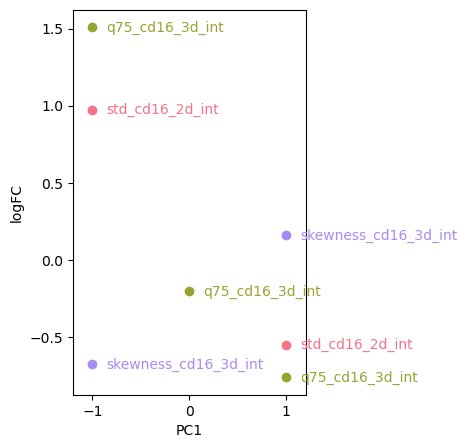

cd3


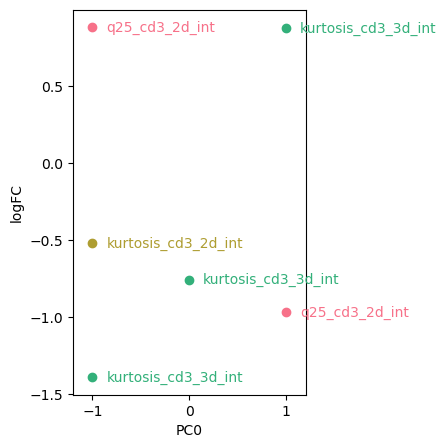

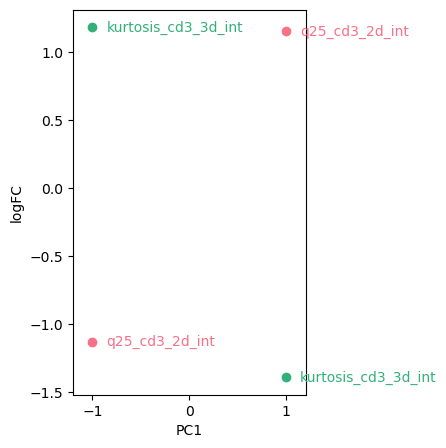

cd4


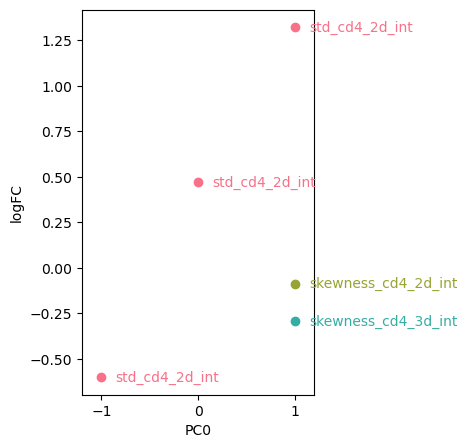

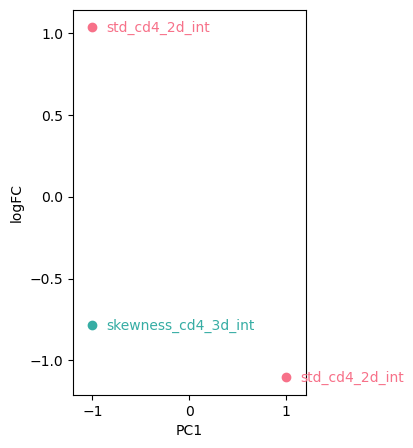

cd8


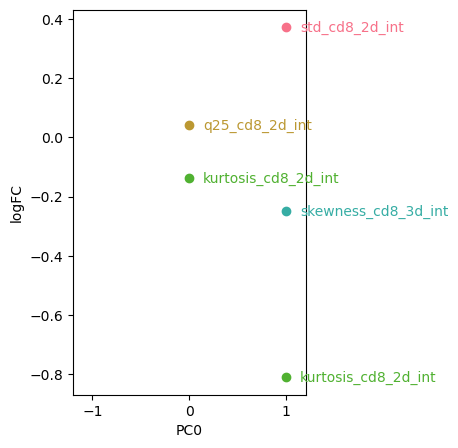

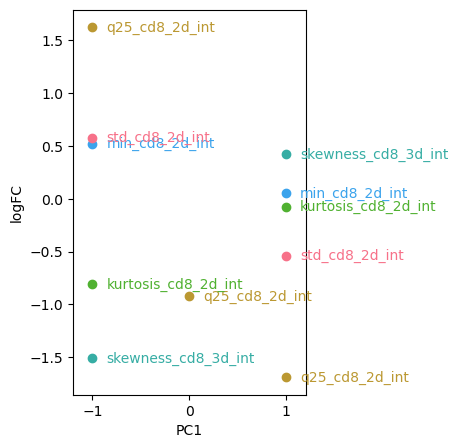

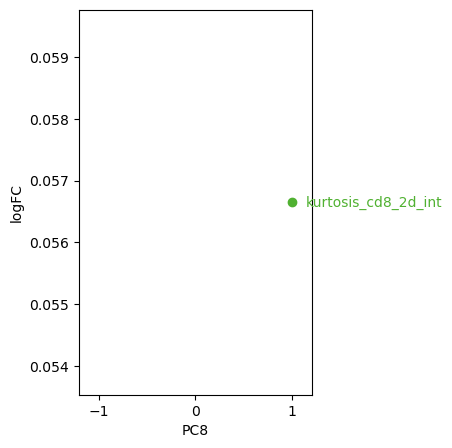

gh2ax


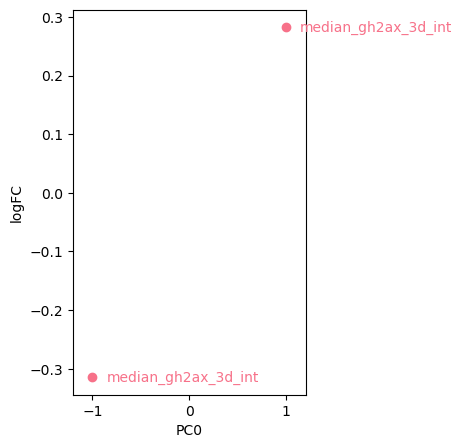

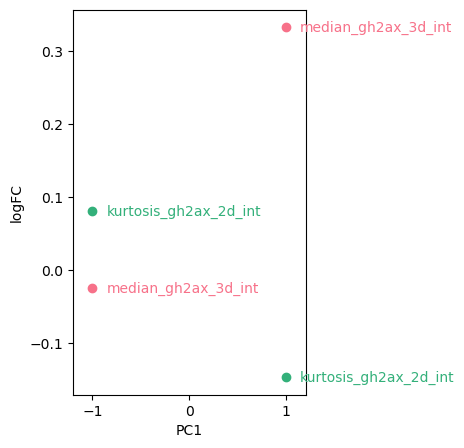

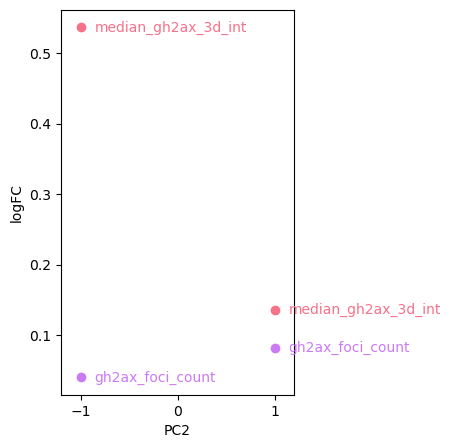

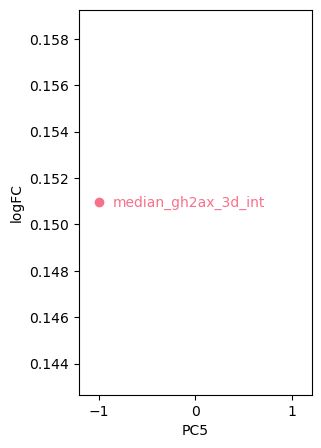

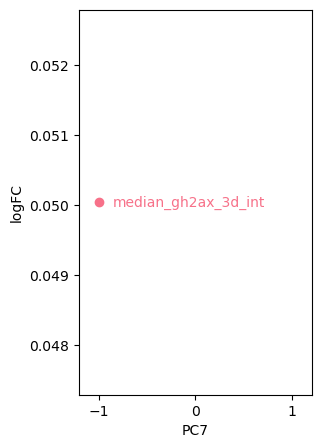

lamin


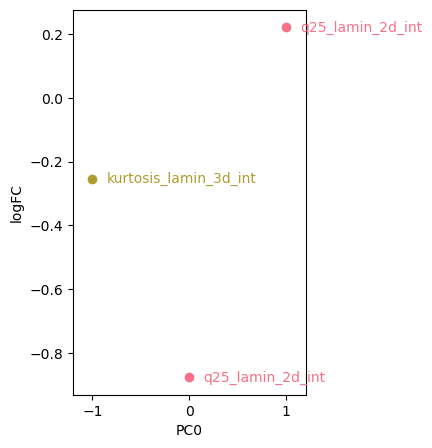

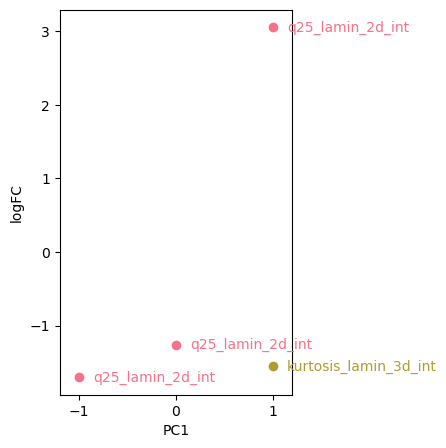

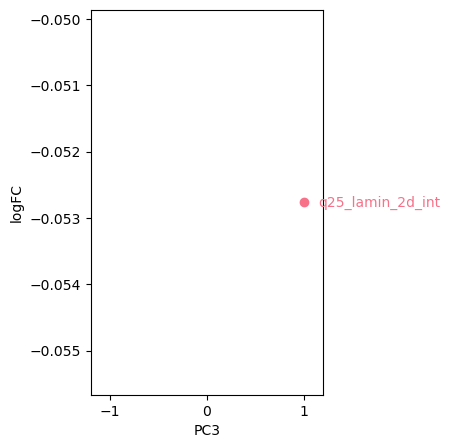

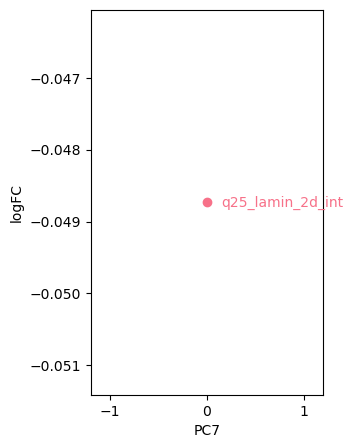

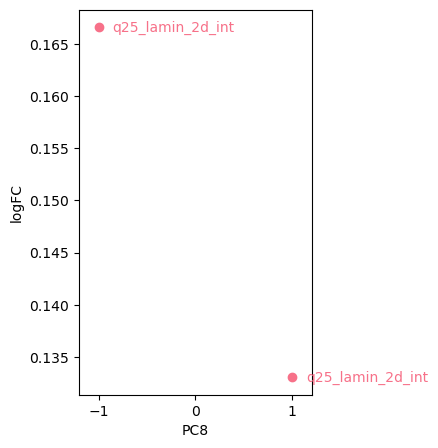

In [58]:
minAgreement=1

dePC_d=10
dePC_d=10

for p in pnames:
    print(p)
    with open(os.path.join(sourceDir,'ls_cc_mostConnected_'+p), 'rb') as output:
        ls_cc_mostConnected=pickle.load(output)
    with open(os.path.join(sourceDir,'nmco_allfeatures_names_finite_'+p), 'rb') as output:
        nmco_names_finite=pickle.load(output)
    colortest=sns.color_palette("husl", len(ls_cc_mostConnected))
    
    for pc_i in range(dePC_d):
        resLogFC={0:np.array([]),-1:np.array([]),1:np.array([])}
        resNames={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        resAgreement={0:np.array([]).astype(str),-1:np.array([]).astype(str),1:np.array([]).astype(str)}
        for h in range(len(holdOutSamples_samples)):
    #         print('sample ',h)
            deRes_d_centered=deD_centered_2bins[h][p]
            deRes_d_centered_heldout=deD_centered_2bins_heldout[h][p]
            for deDirection in resLogFC.keys():
    #             print(deDirection)
                if str(deDirection) not in deRes_d_centered[pc_i] or str(deDirection) not in deRes_d_centered_heldout[pc_i]:
                    continue
                resNames_h_val=nmco_names_finite[deRes_d_centered[pc_i][str(deDirection)].names.astype(int)[np.logical_and(deRes_d_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]]
                resValues_h_val=deRes_d_centered[pc_i][str(deDirection)].logfoldchanges[np.logical_and(deRes_d_centered[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]
                resNames_h_val,mostConnectedIdx,_=np.intersect1d(resNames_h_val,ls_cc_mostConnected,return_indices=True)
                resValues_h_val=np.array(resValues_h_val)[mostConnectedIdx]

                resNames_h_heldout=nmco_names_finite[deRes_d_centered_heldout[pc_i][str(deDirection)].names.astype(int)[np.logical_and(deRes_d_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]]
                resValues_h_heldout=deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges[np.logical_and(deRes_d_centered_heldout[pc_i][str(deDirection)].pvals_adj<pval_thresh,np.abs(deRes_d_centered_heldout[pc_i][str(deDirection)].logfoldchanges)>np.log2(fc_thresh))]
                resNames_h_heldout,mostConnectedIdx,_=np.intersect1d(resNames_h_heldout,ls_cc_mostConnected,return_indices=True)
                resValues_h_heldout=np.array(resValues_h_heldout)[mostConnectedIdx]

                resNames_h,valIdx_h,heldoutIdx_h=np.intersect1d(resNames_h_val,resNames_h_heldout,return_indices=True)
                sameDir=np.equal(resValues_h_val[valIdx_h]>0,resValues_h_heldout[heldoutIdx_h]>0)

                resAgreement[deDirection]=np.concatenate((resAgreement[deDirection],resNames_h[sameDir]))
                for fidx in range(np.sum(sameDir)):
                    f=str(resNames_h[sameDir][fidx])
                    if f not in resNames[deDirection]:
                        resNames[deDirection]=np.concatenate((resNames[deDirection],[f]))
                        resLogFC[deDirection]=np.concatenate((resLogFC[deDirection],[resValues_h_val[valIdx_h[sameDir]][fidx]]))
                    else:
                        fidx_res=np.where(resNames[deDirection]==f)
                        resLogFC[deDirection][fidx_res]+=resValues_h_val[valIdx_h[sameDir]][fidx]
    #                 if f=='homogeneity_100':
    #                     print(resValues_h_val[valIdx_h[sameDir]][fidx])
    #                     print(resValues_h_heldout[heldoutIdx_h[sameDir]][fidx])
        plotCounts=0
        fig, ax = plt.subplots(figsize=(3, 5))
        for deDirection in resLogFC.keys():
            resNames_agree,resAgreement_counts=np.unique(resAgreement[deDirection],return_counts=True)
            resNames_agree=resNames_agree[resAgreement_counts>=minAgreement]
            _,plotIdx,_=np.intersect1d(resNames[deDirection],resNames_agree,return_indices=True)
            plotCounts+=plotIdx.size
            for fidx in range(plotIdx.size):
                ax.scatter(deDirection,resLogFC[deDirection][plotIdx[fidx]]/len(holdOutSamples_samples),color=colortest[ls_cc_mostConnected.index(resNames[deDirection][plotIdx[fidx]])])
                ax.annotate(resNames[deDirection][plotIdx[fidx]],(deDirection,resLogFC[deDirection][plotIdx[fidx]]/len(holdOutSamples_samples)),xytext=(10,-3),textcoords='offset points',color=colortest[ls_cc_mostConnected.index(resNames[deDirection][plotIdx[fidx]])])
        if plotCounts>0:
            ax.set_xlabel('PC'+str(pc_i))
            ax.set_ylabel('logFC')
            ax.set_xlim(-1.2,1.2)
            ax.set_xticks([-1,0,1])
            plt.savefig(os.path.join(plotsavepath_de_pc,p+str(pc_i)+'d.pdf'))
            plt.show()
        else:
            plt.close()